In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

%matplotlib inline
from termcolor import colored, cprint
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "cursive"

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
#from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('/content/Stores.csv')
df = df.drop('Store ID ',axis=1)

Text(0.5, 1.0, 'Distribution of Missing Values')

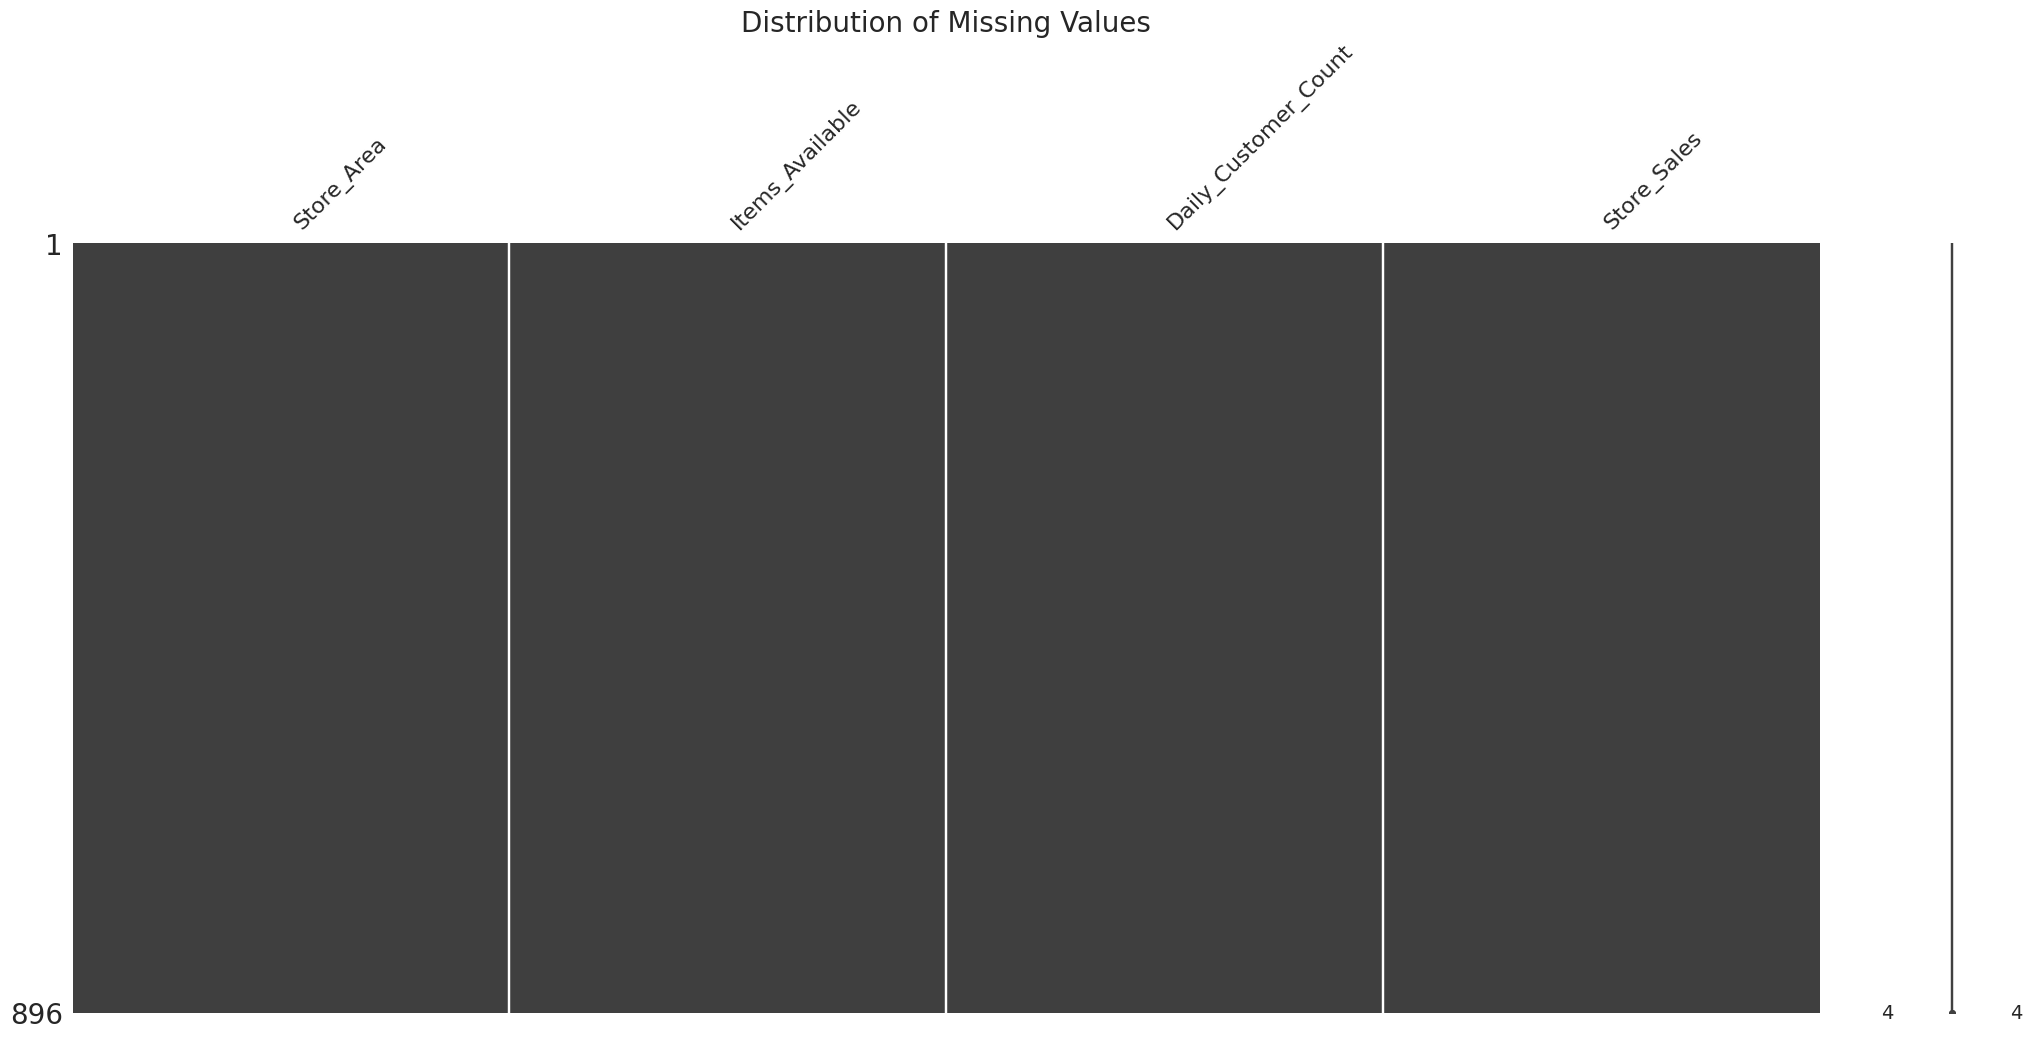

In [ ]:
msno.matrix(df).set_title('Distribution of Missing Values', fontsize = 20)


In [ ]:
print('Shape of DataFrame: ',df.shape,'\n')
df.tail(5)

Shape of DataFrame:  (896, 4) 



,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
891,1582,1910,1080,66390
892,1387,1663,850,82080
893,1200,1436,1060,76440
894,1299,1560,770,96610
895,1174,1429,1110,54340


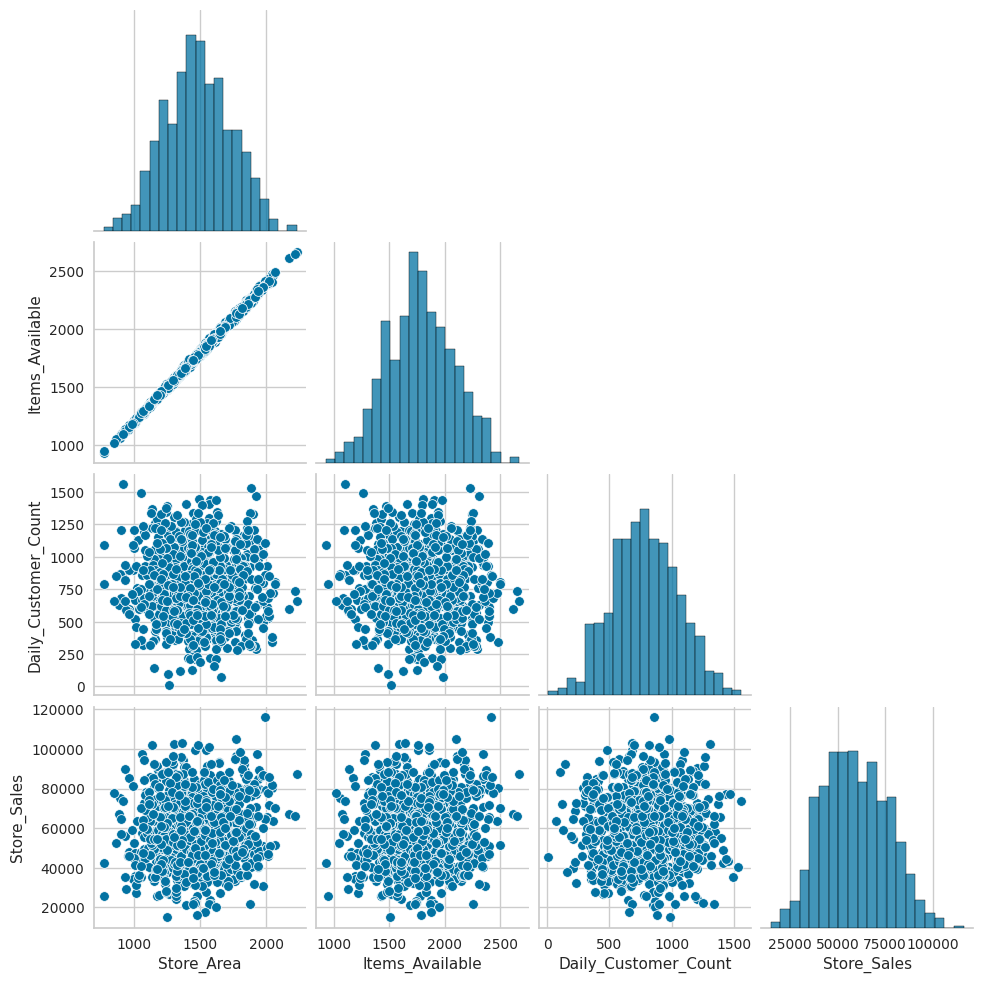

In [ ]:
sns.pairplot(df,corner=True,)

In [ ]:
columns = df.columns.tolist()

fig = go.Figure()
fig.add_trace(go.Box(y=df[columns[0]], name=columns[0],
                marker_color = '#1589FF'))
fig.add_trace(go.Box(y=df[columns[1]], name = columns[1],
                marker_color = '#659EC7'))
fig.add_trace(go.Box(y=df[columns[2]], name = columns[2],
                marker_color = '#00BFFF'))

fig.update_layout(
    font=dict(size=19,family="Franklin Gothic"),
    template='simple_white',
    title = 'Features (BoxPlot)')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=df[columns[3]], name=columns[3],
                marker_color = '#B0CFDE'))

fig.update_layout(
    font=dict(size=19,family="Franklin Gothic"),
    template='simple_white',
    title = 'Target Column (BoxPlot)')
fig.show()

Text(0.5, 1.0, 'Correlation Plot')

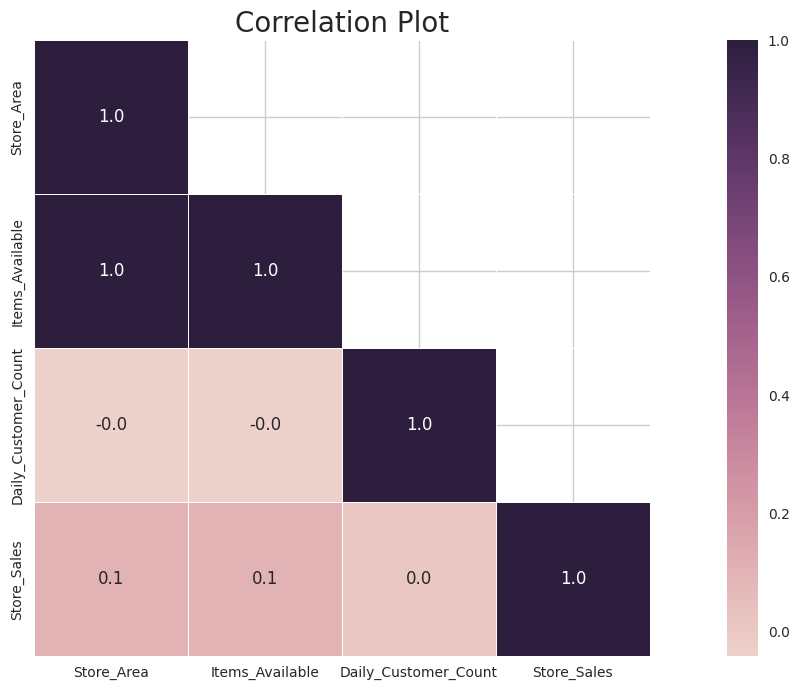

In [ ]:
mask = np.array(df.corr())
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots() 
fig.set_size_inches(20,8)
sns.heatmap(df.corr(), 
            mask = mask, 
            square = True,
            annot = True, 
            fmt=".1f", 
            linewidth=.6,
            cmap=sns.cubehelix_palette(as_cmap=True)).set_title('Correlation Plot',fontsize=20)

In [ ]:
columns = df.columns.tolist()

# to remove outliers in features
def remove_outliers(column):
    idx = []
    Q1 = np.percentile(column, 25, interpolation = 'midpoint')
    Q3 = np.percentile(column, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    upper = np.where(column >= (Q3+1.5*IQR))
    lower = np.where(column <= (Q1-1.5*IQR))
    column = column.drop(upper[0])
    column = column.drop(lower[0])
    return column

# to merge dataframe with series
def create_new_dataframe(dataframe):
    lst = []
    columns = df.columns.tolist()[:-1]
    for column in columns:
        lst.append(remove_outliers(df[column]))
    return pd.concat(lst,axis=1).dropna()

df  = pd.concat([create_new_dataframe(df),df['Store_Sales']], axis=1).dropna().reset_index().drop('index',axis=1)

df.tail()

<ipython-input-18-fef3946452fa>:6: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)

<ipython-input-18-fef3946452fa>:7: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)

<ipython-input-18-fef3946452fa>:6: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)

<ipython-input-18-fef3946452fa>:7: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additi

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
883,1582.0,1910.0,1080.0,66390
884,1387.0,1663.0,850.0,82080
885,1200.0,1436.0,1060.0,76440
886,1299.0,1560.0,770.0,96610
887,1174.0,1429.0,1110.0,54340


In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=df[columns[0]], name=columns[0],
                marker_color = '#1589FF'))
fig.add_trace(go.Box(y=df[columns[1]], name = columns[1],
                marker_color = '#659EC7'))
fig.add_trace(go.Box(y=df[columns[2]], name = columns[2],
                marker_color = '#00BFFF'))

fig.update_layout(
    font=dict(size=19,family="Franklin Gothic"),
    template='simple_white',
    title = 'Features (BoxPlot)')
fig.show()

In [ ]:
y = df['Store_Sales']
X = df.drop('Store_Sales',axis=1)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

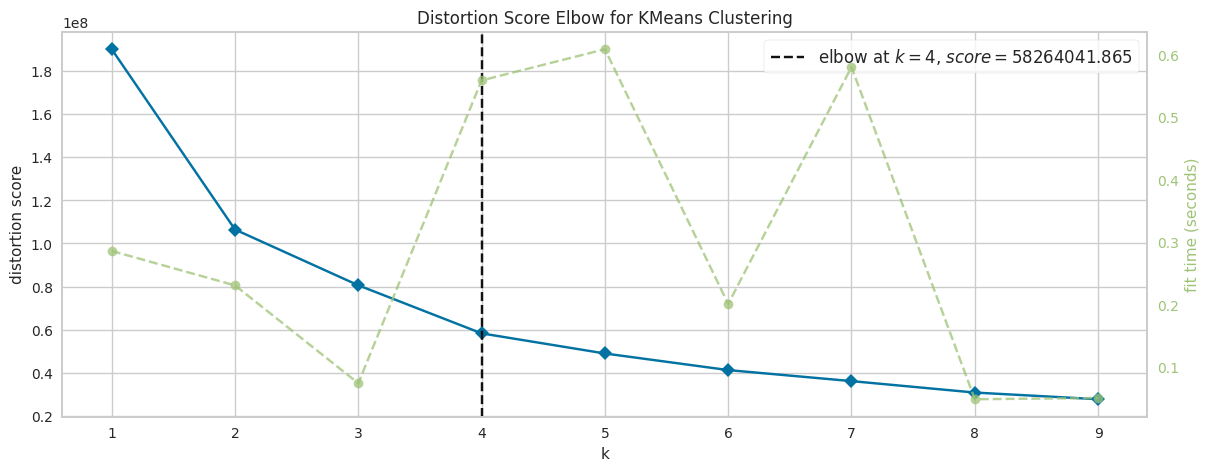

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10),size=(1400, 500))

visualizer.fit(X)        
visualizer.show()

In [ ]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(X)
pred_labels = kmeanModel.labels_;
X['cluster1'] = pred_labels
new_df = pd.DataFrame(columns = ['cluster1','Store_Sales'])
new_df['cluster1'] = X['cluster1']
new_df['Store_Sales'] = y
new_df.head(3)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,cluster1,Store_Sales
0,3,66490
1,3,39820
2,3,54010


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

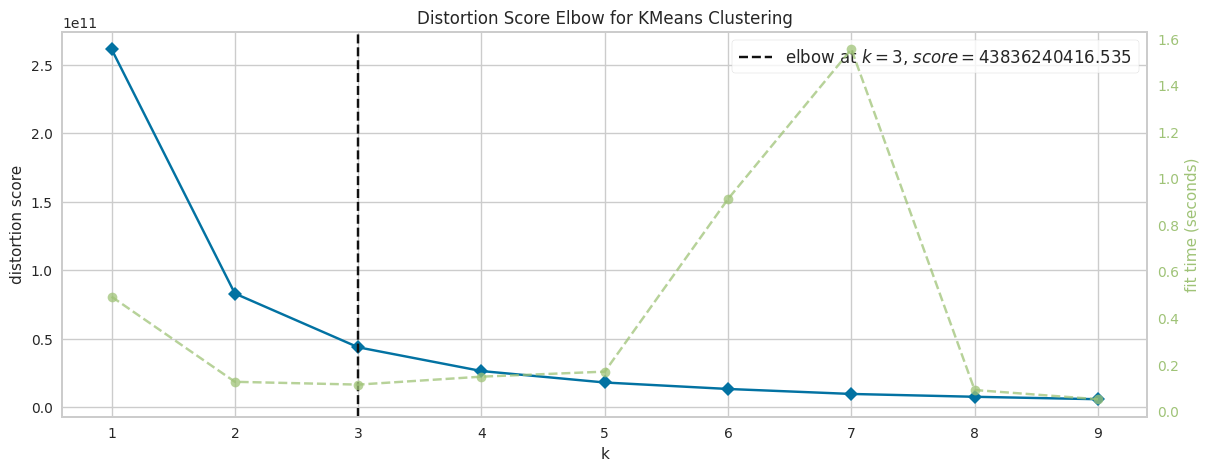

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10),size=(1400, 500))

visualizer.fit(new_df)        
visualizer.show() 

In [ ]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(new_df)
pred_labels = kmeanModel.labels_;
new_df['cluster_2'] = pred_labels

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
new_df = new_df.drop('Store_Sales',axis=1)
X['cluster_2'] = new_df['cluster_2']
X.head()

,Store_Area,Items_Available,Daily_Customer_Count,cluster1,cluster_2
0,1659.0,1961.0,530.0,3,2
1,1461.0,1752.0,210.0,3,1
2,1340.0,1609.0,720.0,3,2
3,1451.0,1748.0,620.0,3,2
4,1770.0,2111.0,450.0,1,1


Classifier: LGBMRegressor 




Fold { 1 }  


MAE Score:  6450.094253857233
MSE Score:  62178176.86123534
RMSE Score:  7885.313998899178
R2 Score:  0.7712219779886721 




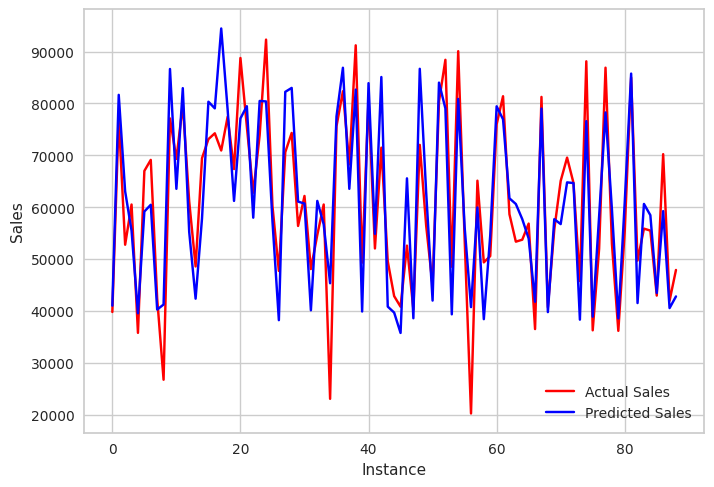

Fold { 2 }  


MAE Score:  6666.936756719669
MSE Score:  68354768.60752985
RMSE Score:  8267.694273951465
R2 Score:  0.7480669837232258 




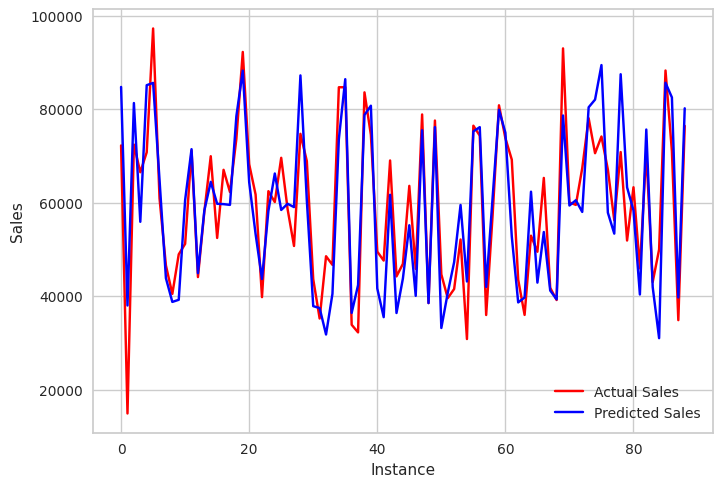

Fold { 3 }  


MAE Score:  6760.842209673356
MSE Score:  68200547.48954499
RMSE Score:  8258.3622764774
R2 Score:  0.7530282641556473 




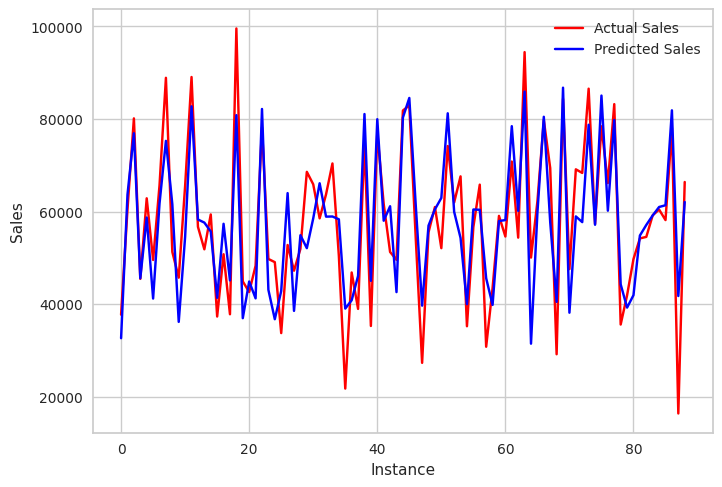

Fold { 4 }  


MAE Score:  5587.51825383572
MSE Score:  48454343.23033841
RMSE Score:  6960.9154017512965
R2 Score:  0.8318406297488018 




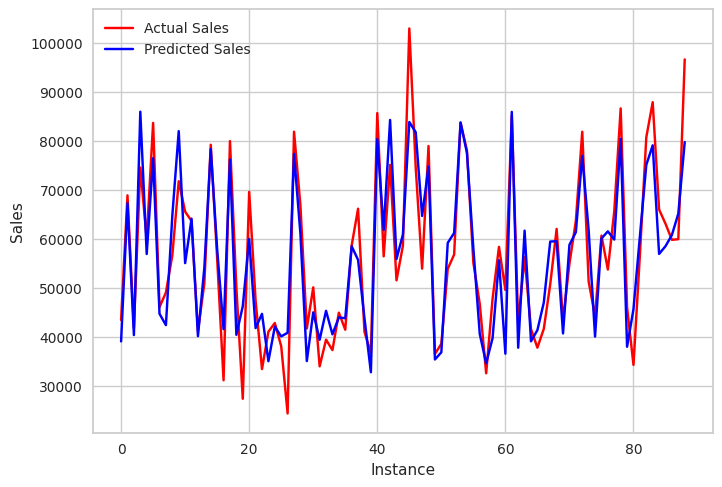

Fold { 5 }  


MAE Score:  6555.786147514716
MSE Score:  70319783.07310839
RMSE Score:  8385.689182953802
R2 Score:  0.7938651993767123 




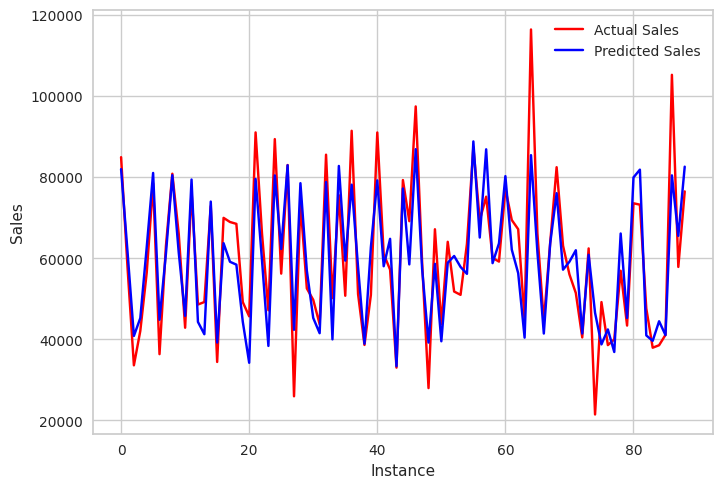

Fold { 6 }  


MAE Score:  6378.956547479365
MSE Score:  66290662.0614174
RMSE Score:  8141.9077654697985
R2 Score:  0.7970009025066853 




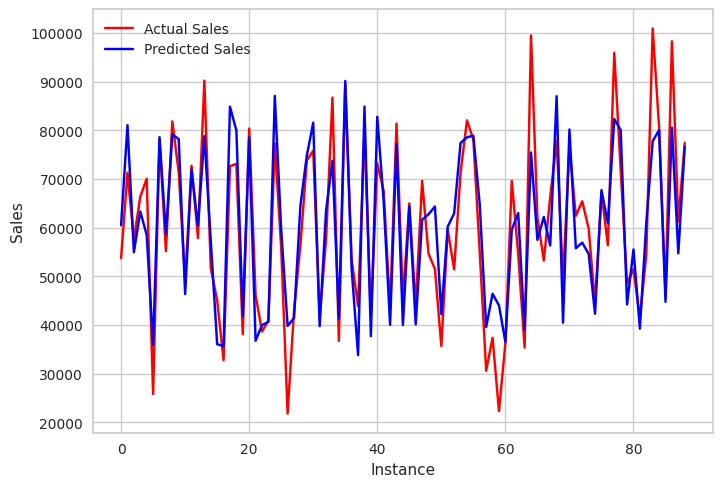

Fold { 7 }  


MAE Score:  7029.220574205729
MSE Score:  79739675.45572744
RMSE Score:  8929.707467533717
R2 Score:  0.7609555474916809 




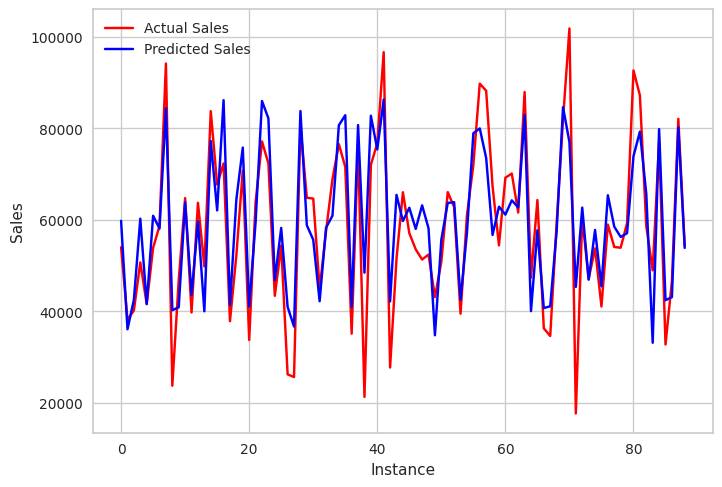

Fold { 8 }  


MAE Score:  5321.731948430069
MSE Score:  47583738.372187205
RMSE Score:  6898.09672099393
R2 Score:  0.8520870122653674 




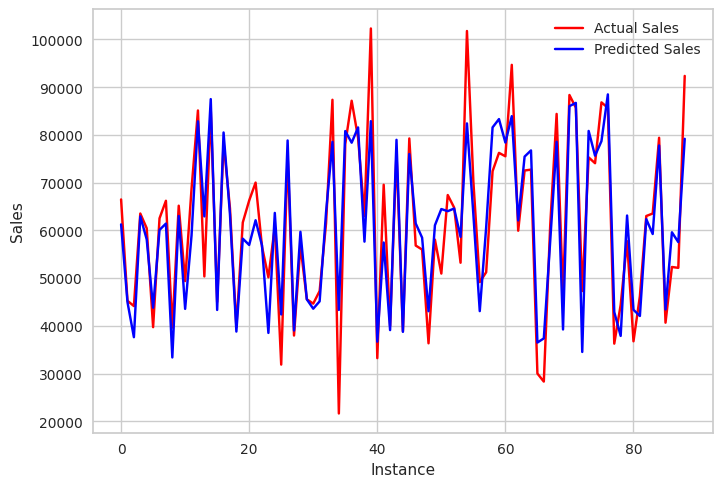

Fold { 9 }  


MAE Score:  5495.607244480516
MSE Score:  45161704.1696169
RMSE Score:  6720.245841456762
R2 Score:  0.808369614085656 




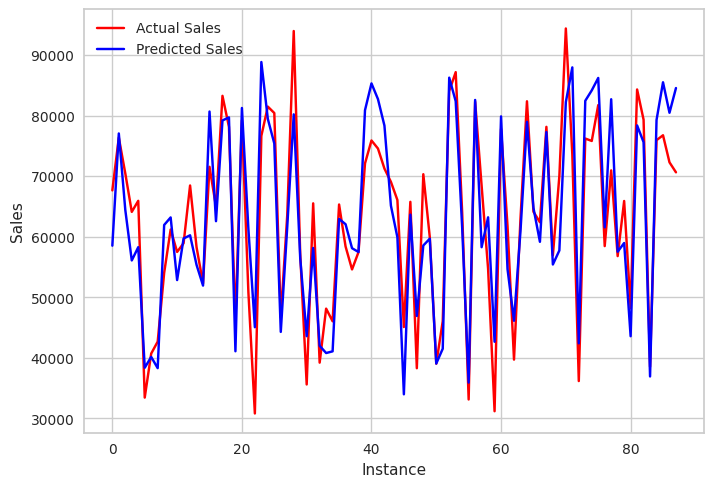

Fold { 10 }  


MAE Score:  5240.760749589576
MSE Score:  41356422.12276319
RMSE Score:  6430.89590358631
R2 Score:  0.8267592890259098 




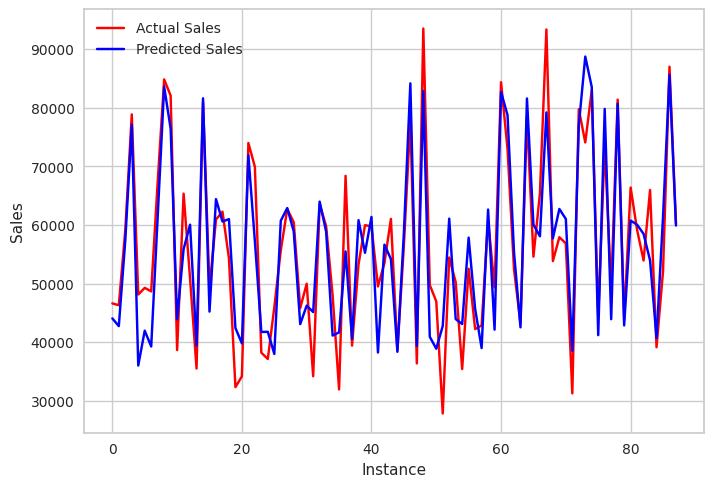

------------------------------------------------------------ 



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np
from termcolor import colored
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class PARAM:
    FOLD = 10
    RANDOM_STATE = 116
    VERBOSE = 0

# scaling function
def Scaler(train_X, val_X):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train_X)
    scaled_val = scaler.transform(val_X)
    return scaled_train, scaled_val

# define models
lgbr = lgb.LGBMRegressor(random_state = PARAM.RANDOM_STATE)

classifiers_name = ['LGBMRegressor']
color_sequence = ['blue']
classifiers = [lgbr]
mae_score = []
mse_score = []
rmse_score = []
R2_score = []


fold = KFold(n_splits=PARAM.FOLD, shuffle=True, random_state=PARAM.FOLD)

# 10 fold
for idx, classifier in enumerate(classifiers):
    mae = 0  
    mse = 0
    rmse = 0
    r2score = 0
    print(colored('Classifier:',color_sequence[idx]) ,colored(classifiers_name[idx],color_sequence[idx]), '\n\n')
    for fold_idx, (train_idx, val_idx) in enumerate(fold.split(X, y)):
        
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        x_train, x_val = Scaler(x_train, x_val)
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = classifier.fit(x_train, y_train)
        val_preds = model.predict(x_val)
        
        mae += mean_absolute_error(y_val, val_preds) / PARAM.FOLD
        mse += mean_squared_error(y_val,val_preds) / PARAM.FOLD
        rmse += np.sqrt(mean_squared_error(y_val, val_preds)) / PARAM.FOLD
        r2score += r2_score(y_val,val_preds)/PARAM.FOLD
        
        print('Fold','{',fold_idx+1,'} ','\n\n')
        print('MAE Score: ', mean_absolute_error(y_val, val_preds))
        print('MSE Score: ', mean_squared_error(y_val,val_preds))
        print('RMSE Score: ', np.sqrt(mean_squared_error(y_val, val_preds)))
        print('R2 Score: ', r2_score(y_val,val_preds),'\n\n')
        
        # plot actual vs predicted graph
        actual_sales = y_val
        predicted_sales = val_preds
        sns.lineplot(x=range(len(actual_sales)), y=actual_sales, color='red', label='Actual Sales')
        sns.lineplot(x=range(len(predicted_sales)), y=predicted_sales, color='blue', label='Predicted Sales')
        plt.xlabel('Instance')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

    mae_score.append(round(mae,2))
    mse_score.append(round(mse,2))
    rmse_score.append(round(rmse,2))
    R2_score.append(round(r2score,2))
    print('---'*20,'\n')





In [ ]:
print('Mean R2 Score:', np.mean(R2_score))

Mean R2 Score: 0.79
